In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


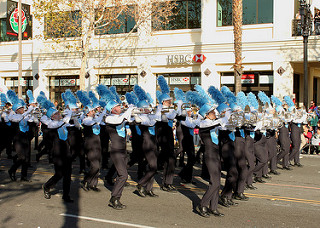

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

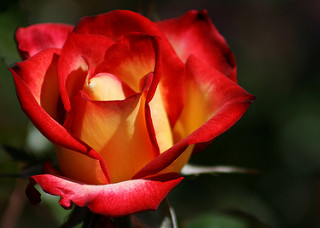

In [7]:
PIL.Image.open(str(roses[1]))

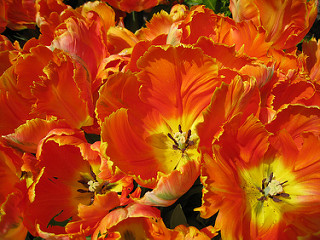

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

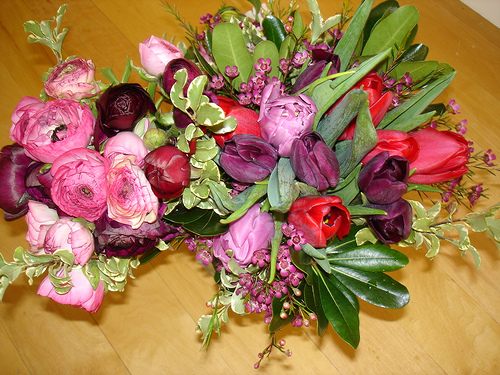

In [9]:
PIL.Image.open(str(tulips[1]))

In [10]:
batch_size=32
img_height=180
img_width=180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


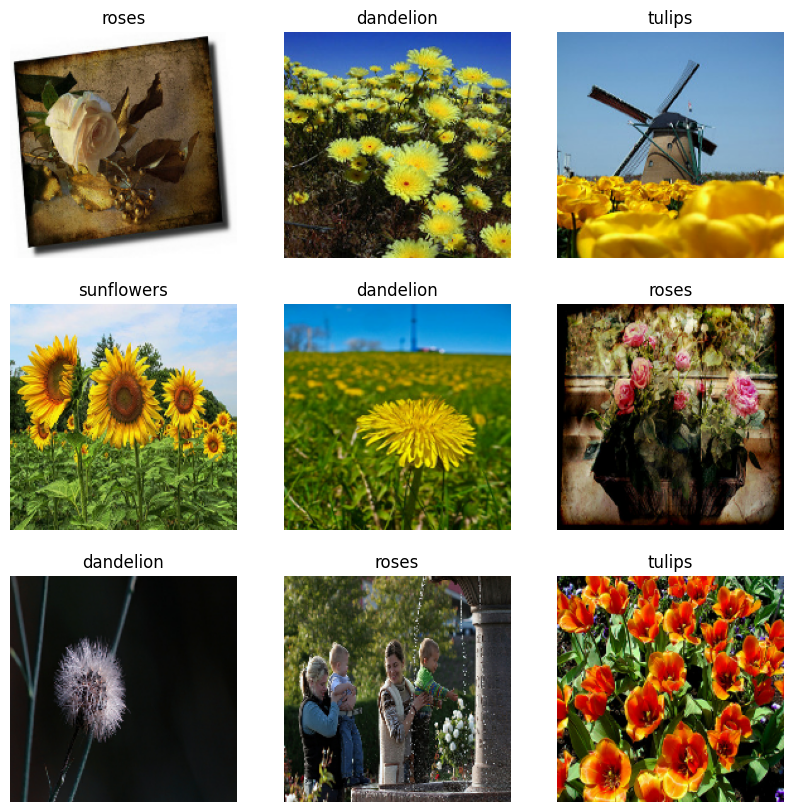

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.008872573 0.7322078


In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 63s 667ms/step - loss: 1.3275 - accuracy: 0.4220 - val_loss: 1.0996 - val_accuracy: 0.5736
Epoch 2/10
92/92 [==============================] - 59s 641ms/step - loss: 0.9960 - accuracy: 0.6155 - val_loss: 0.9978 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 58s 630ms/step - loss: 0.8104 - accuracy: 0.6884 - val_loss: 0.9094 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 59s 636ms/step - loss: 0.5937 - accuracy: 0.7837 - val_loss: 1.0537 - val_accuracy: 0.5954
Epoch 5/10
92/92 [==============================] - 60s 649ms/step - loss: 0.3627 - accuracy: 0.8716 - val_loss: 1.1285 - val_accuracy: 0.6131
Epoch 6/10
92/92 [==============================] - 59s 643ms/step - loss: 0.2341 - accuracy: 0.9227 - val_loss: 1.2329 - val_accuracy: 0.6676
Epoch 7/10
92/92 [==============================] - 60s 656ms/step - loss: 0.1241 - accuracy: 0.9625 - val_loss: 1.3293 - val_accuracy: 0.6349

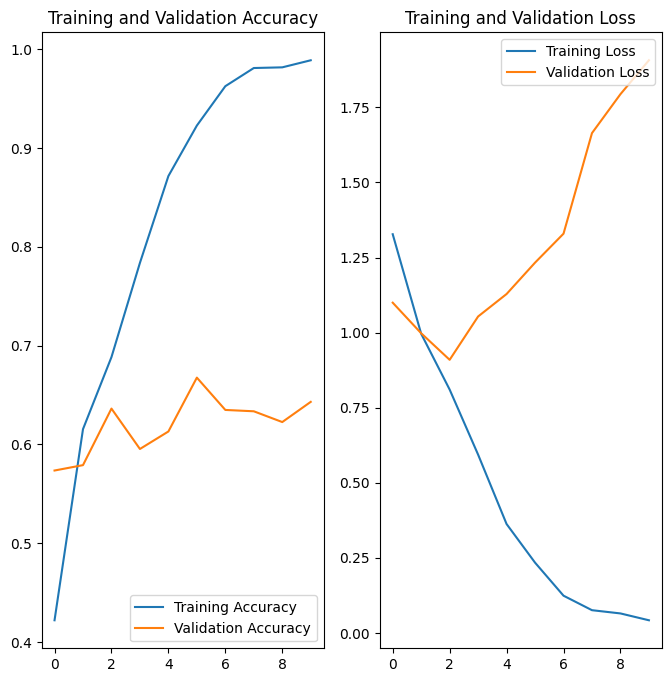

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

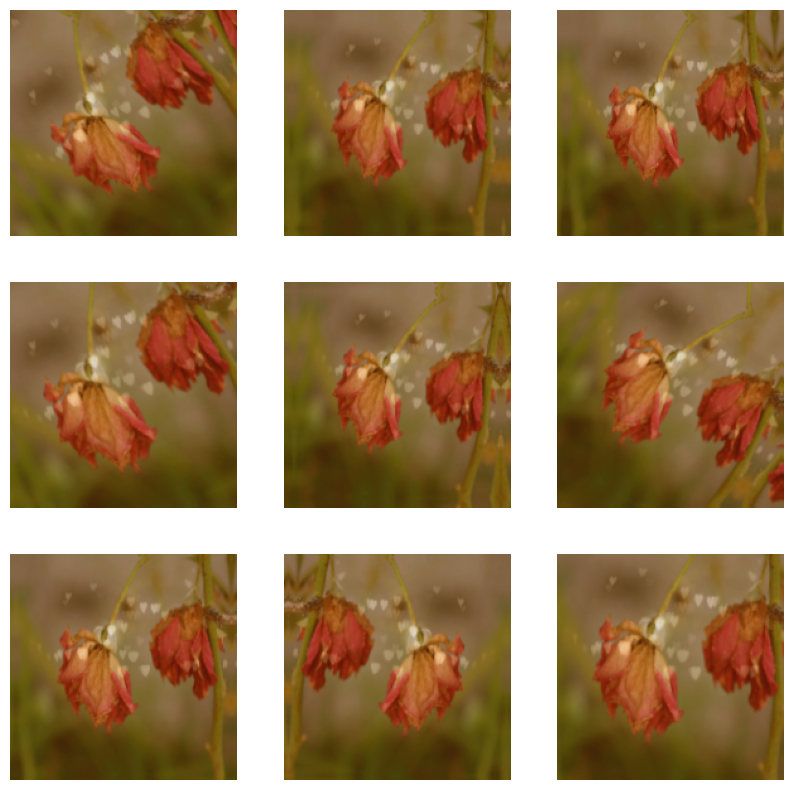

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [29]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [31]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 72s 769ms/step - loss: 1.3204 - accuracy: 0.4326 - val_loss: 1.1337 - val_accuracy: 0.5259
Epoch 2/15
92/92 [==============================] - 69s 756ms/step - loss: 1.0224 - accuracy: 0.5865 - val_loss: 1.0848 - val_accuracy: 0.5763
Epoch 3/15
92/92 [==============================] - 69s 747ms/step - loss: 0.9410 - accuracy: 0.6287 - val_loss: 0.9152 - val_accuracy: 0.6444
Epoch 4/15
92/92 [==============================] - 69s 756ms/step - loss: 0.8701 - accuracy: 0.6638 - val_loss: 1.0073 - val_accuracy: 0.6076
Epoch 5/15
92/92 [==============================] - 69s 747ms/step - loss: 0.8138 - accuracy: 0.6901 - val_loss: 0.8586 - val_accuracy: 0.6540
Epoch 6/15
92/92 [==============================] - 69s 754ms/step - loss: 0.7846 - accuracy: 0.6955 - val_loss: 0.8265 - val_accuracy: 0.6812
Epoch 7/15
92/92 [==============================] - 69s 746ms/step - loss: 0.7625 - accuracy: 0.7074 - val_loss: 0.7591 - val_accuracy: 0.7166

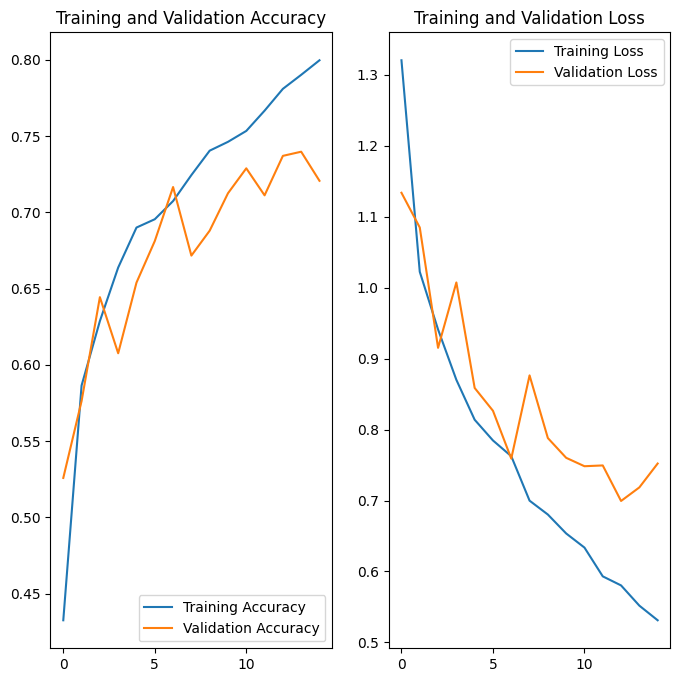

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 98ms/step
This image most likely belongs to sunflowers with a 93.25 percent confidence.


In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [35]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [36]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_2_input'], 'outputs': ['outputs']}}

In [37]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [49]:
predictions_lite = classify_lite(sequential_2_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [51]:
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite)))


This image most likely belongs to sunflowers with a 93.25 percent confidence.


In [52]:
print(np.max(np.abs(predictions - predictions_lite)))

2.3841858e-06
